# Description

In this notebook, I will train the CNN model in the FL system. During the training, I will prune the filters of the CNN.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.random.set_seed(42)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:  tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e: print(e)

import gc
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize

from sklearn.model_selection import train_test_split

from utils.read_data_utils import *
from utils.model_utils import *
from utils.pruning_utils import *
from config_celeb import *

2024-05-21 21:25:04.942794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 21:25:04.942819: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 21:25:04.942836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Dataset

## 1.1. Load dataset

In [3]:
celeb_train, celeb_test = tff.simulation.datasets.celeba.load_data()

num_clients = len(celeb_train.client_ids)
print(f"Number of clients: {num_clients}")

Number of clients: 8408


## 1.2. Prepare training dataset

In [4]:
list_clients_data = Create_Clients_Data(celeb_train, DATASET_NAME)
print(f"Number of client: {len(list_clients_data)}")

Number of client: 8408


Shape of image: (84, 84, 3)
Max value of X: 255
Min value of X: 0
Client = 10002
Label = [1. 0.]


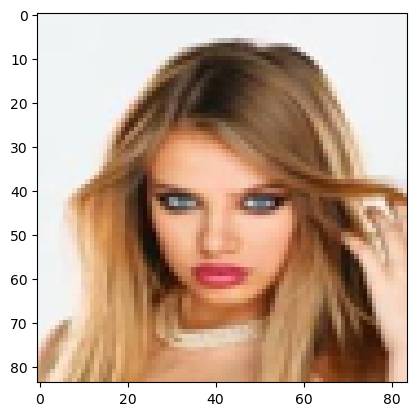

In [5]:
idx_client = np.random.randint(0, 10)
idx_sample = np.random.randint(0, 10)

client_data = list_clients_data[idx_client]

client_name = client_data['client_name']
list_X = client_data['list_X']
list_y = client_data['list_y']

X = list_X[idx_sample]
print(f"Shape of image: {X.shape}")
print(f"Max value of X: {X.max()}")
print(f"Min value of X: {X.min()}")

y = list_y[idx_sample]

print(f"Client = {client_name}")
print(f"Label = {y}")
plt.imshow(X, cmap='gray')
plt.show()

## 1.3. Prepare val - test dataset

In [6]:
list_data_test = Create_Clients_Data(celeb_test, dataset_name=DATASET_NAME)

X_test = []
y_test = []
for data_test in list_data_test:
    X_test.append(data_test['list_X'])
    y_test.append(data_test['list_y'])
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_val = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_val])
X_test = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_test])

In [7]:
print(f"Shape of X val: {X_val.shape}")
print(f"Shape of y val: {y_val.shape}")
print(f"Max value of X_val: {X_val[3].max()}")
print(f"Min value of X_val: {X_val[3].min()}")
print()
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X val: (9929, 84, 84, 3)
Shape of y val: (9929, 2)
Max value of X_val: 1.0
Min value of X_val: 0.0

Shape of X test: (9930, 84, 84, 3)
Shape of y test: (9930, 2)


# 2. Training FL

## 2.1. Define components

In [8]:
def Define_Simple_CNN_Model(input_shape, output_shape, list_number_filters, kernel_size = 5, max_pooling_step=2, model_name=None):
    """
    This function create the simple CNN model. 
    """
    
    model = models.Sequential(name=model_name)
    model.add(Input(input_shape))

    for (idx_filter, number_filter) in enumerate(list_number_filters):
        model.add(Conv2D(number_filter, (kernel_size, kernel_size), name=f'prunable_conv_{idx_filter}', padding='same'))
        # model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=max_pooling_step, strides=max_pooling_step))

    model.add(layers.Flatten())
    # model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(output_shape, activation='softmax', name='classifier'))
    return model

In [9]:
keras.backend.clear_session()

# global_model = Define_ResNet_Model(input_shape=INPUT_SHAPE, output_shape=OUPUT_SHAPE, list_number_filters=LIST_NUMBER_FILTERS, model_name="global_model")

global_model = Define_Simple_CNN_Model(INPUT_SHAPE, OUPUT_SHAPE, LIST_NUMBER_FILTERS, model_name="global_model")

global_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
global_model.summary()

plot_model(global_model, to_file=os.path.join('images', f'model_architecture_{DATASET_NAME}.png'), show_shapes=True, show_layer_names=True);
global_model.save(PATH_GLOBAL_MODEL)

Model: "global_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prunable_conv_0 (Conv2D)    (None, 84, 84, 32)        2432      
                                                                 
 activation (Activation)     (None, 84, 84, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 32)        0         
 D)                                                              
                                                                 
 prunable_conv_1 (Conv2D)    (None, 42, 42, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 42, 42, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                 

/home/necphy/miniconda3/envs/fl_env/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 2.2. FL training

In [10]:
NUM_CLIENTS = num_clients
list_val_acc = []
list_val_loss = []
list_model_params = []


for idx_round in range(NUM_ROUNDS):
    print("\n [INFO] Round {}".format(idx_round))
    global_model = tf.keras.models.load_model(PATH_GLOBAL_MODEL)
    global_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics = METRICS)
    
    client_model = keras.models.clone_model(global_model)    
    client_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    
    selected_clients_data = random.sample(list_clients_data, NUM_SELECTED_CLIENT)

    # Loop through selected client
    list_client_model_weight = []
    list_client_scales = []
    for selectd_client_data in selected_clients_data:      

        # Clone client's weight from global model
        client_model.set_weights(global_model.get_weights())

        client_name = selectd_client_data['client_name']
        list_X = selectd_client_data['list_X']
        list_y = selectd_client_data['list_y']
        list_X = list_X.astype(np.float32) / 255.0

        client_model.fit(list_X, list_y, epochs=LOCAL_EPOCHS, batch_size=LOCAL_BATCH_SIZE, verbose=0)

        list_client_model_weight.append(client_model.get_weights())    # store local weight for update global model later.
        list_client_scales.append(len(list_X))

    
    # Calculate scale of each client
    list_client_scales = np.array(list_client_scales)
    list_client_scales = list_client_scales / list_client_scales.sum()

    # Update the global model weights
    avg_weights = FedAvg(global_model, list_client_model_weight, list_client_scales)
    global_model.set_weights(avg_weights)

    # Evaluate model on validation data
    if idx_round % 10 == 0:
        val_loss, val_acc = global_model.evaluate(X_val, y_val, verbose=0)
        print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')
        list_val_acc.append(val_acc)
        list_val_loss.append(val_loss)

    global_model.save(PATH_GLOBAL_MODEL)
    selected_clients_data = None
    list_client_model_weight = list_client_scales = None
    tf.keras.backend.clear_session()
    gc.collect()


 [INFO] Round 0
Val loss: 0.6783447265625, Val accuracy: 0.6062040328979492

 [INFO] Round 1

 [INFO] Round 2

 [INFO] Round 3

 [INFO] Round 4

 [INFO] Round 5

 [INFO] Round 6

 [INFO] Round 7

 [INFO] Round 8

 [INFO] Round 9

 [INFO] Round 10
Val loss: 1.3595213890075684, Val accuracy: 0.5881760716438293

 [INFO] Round 11

 [INFO] Round 12

 [INFO] Round 13

 [INFO] Round 14

 [INFO] Round 15

 [INFO] Round 16

 [INFO] Round 17

 [INFO] Round 18

 [INFO] Round 19

 [INFO] Round 20
Val loss: 0.8509871959686279, Val accuracy: 0.6023768782615662

 [INFO] Round 21

 [INFO] Round 22

 [INFO] Round 23

 [INFO] Round 24

 [INFO] Round 25

 [INFO] Round 26

 [INFO] Round 27

 [INFO] Round 28

 [INFO] Round 29

 [INFO] Round 30
Val loss: 0.5290148258209229, Val accuracy: 0.7446872591972351

 [INFO] Round 31

 [INFO] Round 32

 [INFO] Round 33

 [INFO] Round 34

 [INFO] Round 35

 [INFO] Round 36

 [INFO] Round 37

 [INFO] Round 38

 [INFO] Round 39

 [INFO] Round 40
Val loss: 0.43345621228

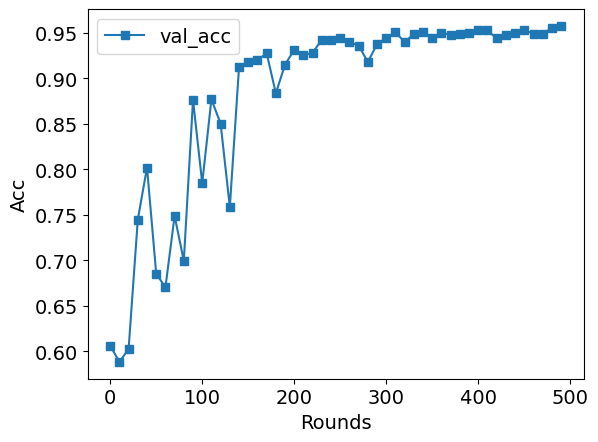

In [11]:
# Sample data arrays
list_rounds = np.arange(0, NUM_ROUNDS, 10)

plt.rcParams.update({'font.size': 14})
plt.plot(list_rounds, list_val_acc, label='val_acc', marker='s')
plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.legend()
plt.show();

# 3. Evaluation

In [12]:
# X_test = np.array([resize(image, (IMAGE_DIMENSION, IMAGE_DIMENSION)) for image in X_test])
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of X test: (9930, 84, 84, 3)
Shape of y test: (9930, 2)


In [13]:
# Evaluate model on testing data
val_loss, val_acc = global_model.evaluate(X_test, y_test, verbose=0)
print(f'Val loss: {val_loss}, Val accuracy: {val_acc}')

Val loss: 0.12184684723615646, Val accuracy: 0.9587109684944153
